# MuJoCoでSACで学習させる
https://qiita.com/key353/items/07aa82e69cc7103db801


mujocoを/root/.mujoco/mujoco210にインストールする必要がある

In [2]:
# test gymnasium
import gymnasium as gym
env = gym.make("Ant-v4", render_mode="human")
env.reset()
for _ in range(1000):
    env.step(env.action_space.sample())
env.close()

Compiling /home/arifuku/kjmlab/kjmlab_intern/.venv/lib/python3.10/site-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /home/arifuku/kjmlab/kjmlab_intern/.venv/lib/python3.10/site-packages/mujoco_py/cymj.pyx


performance hint: /home/arifuku/kjmlab/kjmlab_intern/.venv/lib/python3.10/site-packages/mujoco_py/cymj.pyx:67:5: Exception check on 'c_warning_callback' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'c_warning_callback' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'c_warning_callback' to allow an error code to be returned.
performance hint: /home/arifuku/kjmlab/kjmlab_intern/.venv/lib/python3.10/site-packages/mujoco_py/cymj.pyx:104:5: Exception check on 'c_error_callback' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'c_error_callback' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'c_error_callback' to allow an error code to be returned.

Error compiling Cython file:
------------------------------------------------------------
...
    See 

CompileError: /home/arifuku/kjmlab/kjmlab_intern/.venv/lib/python3.10/site-packages/mujoco_py/cymj.pyx

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo


In [4]:

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# アクターネットワークの定義
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim * 2)
        )
        self.max_action = max_action

    def forward(self, state):
        mean, log_std = self.net(state).chunk(2, dim=-1)
        log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t) - torch.log(1 - action.pow(2) + 1e-6)
        return action * self.max_action, log_prob.sum(1, keepdim=True)

# クリティックネットワークの定義
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))

# SACエージェントの定義
class SAC:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_target_1 = Critic(state_dim, action_dim).to(device)
        self.critic_target_2 = Critic(state_dim, action_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=3e-4)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=3e-4)

        self.critic_target_1.load_state_dict(self.critic_1.state_dict())
        self.critic_target_2.load_state_dict(self.critic_2.state_dict())

        self.max_action = max_action
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action, _ = self.actor.sample(state)
        return action.cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action, next_log_pi = self.actor.sample(next_state)
            target_Q1 = self.critic_target_1(next_state, next_action)
            target_Q2 = self.critic_target_2(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2) - self.alpha * next_log_pi
            target_Q = reward + not_done * self.gamma * target_Q

        current_Q1 = self.critic_1(state, action)
        current_Q2 = self.critic_2(state, action)
        critic_loss = nn.MSELoss()(current_Q1, target_Q) + nn.MSELoss()(current_Q2, target_Q)

        self.critic_1_optimizer.zero_grad()
        self.critic_2_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.step()

        action, log_pi = self.actor.sample(state)
        Q1 = self.critic_1(state, action)
        Q2 = self.critic_2(state, action)
        Q = torch.min(Q1, Q2)
        actor_loss = (self.alpha * log_pi - Q).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param, target_param in zip(self.critic_1.parameters(), self.critic_target_1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.critic_2.parameters(), self.critic_target_2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# リプレイバッファの定義
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


In [7]:

# 環境の作成関数
def make_env(episode):
    env = gym.make("Ant-v4", render_mode="rgb_array")
    if episode in [0, 499, 999]:  # エピソード1, 500, 1000で記録
        env = RecordVideo(env, f"videos/episode_{episode+1}")
    return env


In [9]:

# トレーニングループ
def train():
    env = gym.make("Ant-v4", render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = SAC(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    num_episodes = 1000
    max_steps = 1000
    batch_size = 256
    rewards = []

    for episode in range(num_episodes):
        env = make_env(episode)
        state, _ = env.reset()
        episode_reward = 0

        for t in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            replay_buffer.add(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward

            if replay_buffer.size > batch_size:
                agent.train(replay_buffer, batch_size)

            if done:
                break

        rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")

        env.close()

    return rewards

# トレーニングの実行
rewards = train()


/root/.cache/pypoetry/virtualenvs/gymnasium-tutorial-GGubfbDK-py3.10/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/gymnasium_tutorial/notebook/videos/episode_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4
Episode 1: Reward = -5.428420300130523


Episode 2: Reward = -42.42588445050857
Episode 3: Reward = -12.854145343060003
Episode 4: Reward = -30.618633745953364
Episode 5: Reward = -420.90248159480103
Episode 6: Reward = -14.265614670497234
Episode 7: Reward = -16.998940095604187
Episode 8: Reward = -41.193603115037845
Episode 9: Reward = -33.86533785951025
Episode 10: Reward = -82.82969247204805
Episode 11: Reward = -41.1051061592058
Episode 12: Reward = -95.4396566265436
Episode 13: Reward = -8.744517206751937
Episode 14: Reward = -390.2818759970022
Episode 15: Reward = -28.297073766825957
Episode 16: Reward = -7.7847659577099355
Episode 17: Reward = -38.43152521843195
Episode 18: Reward = -344.90111829263924
Episode 19: Reward = -160.38408204547846
Episode 20: Reward = -39.54210456949586
Episode 21: Reward = -76.97565343072336
Episode 22: Reward = -20.494206274606395
Episode 23: Reward = -63.066901288036775
Episode 24: Reward = -3.7087018220581953
Episode 25: Reward = -13.767475790968422
Episode 26: Reward = -0.676221919333

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_500/rl-video-episode-0.mp4
Episode 500: Reward = 35.78100108030765


Episode 501: Reward = 1658.3070356764533
Episode 502: Reward = 781.1231909200214
Episode 503: Reward = 1815.9976507273811
Episode 504: Reward = 752.9940302324771
Episode 505: Reward = 1938.1503082707713
Episode 506: Reward = 1893.0580600759517
Episode 507: Reward = 499.4128869975515
Episode 508: Reward = 1835.4516413170873
Episode 509: Reward = 1972.1852403980795
Episode 510: Reward = 1590.8047308576806
Episode 511: Reward = 393.2144581979011
Episode 512: Reward = 1261.8849126944758
Episode 513: Reward = 1099.1688953005985
Episode 514: Reward = 728.9853515672949
Episode 515: Reward = 923.775225075129
Episode 516: Reward = 335.87802430803686
Episode 517: Reward = 836.7325239924841
Episode 518: Reward = 556.049925892387
Episode 519: Reward = 1213.9452976901857
Episode 520: Reward = 1118.6292169365702
Episode 521: Reward = 264.8017258855939
Episode 522: Reward = 690.2411767521951
Episode 523: Reward = 636.788444092691
Episode 524: Reward = 2257.6501247036413
Episode 525: Reward = 452.6349

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_1000/rl-video-episode-0.mp4
Episode 1000: Reward = 4451.397487143979


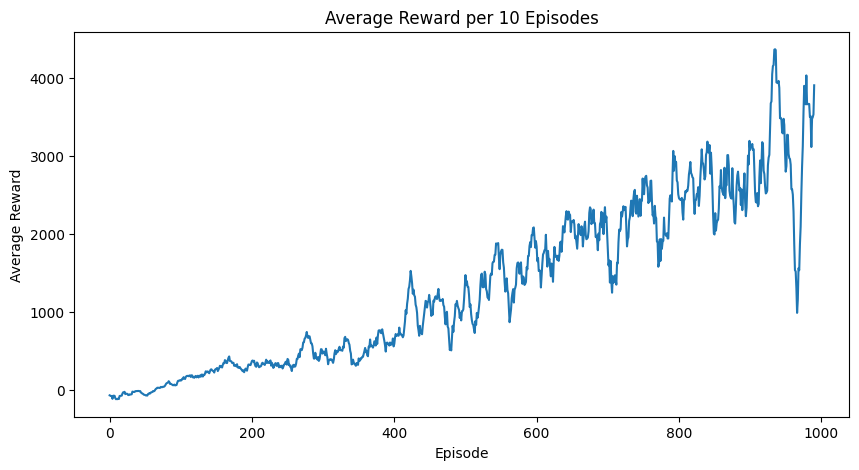

動画は videos ディレクトリに保存されています。


In [11]:

# 報酬の平均推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'))
plt.title('Average Reward per 10 Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.savefig('reward_plot.png')
plt.show()

print("動画は videos ディレクトリに保存されています。")